In [1]:
######################################################################################################################
# Output of this script - 6 files:
#
#   glove.6B.50d.txt  - pre-trained glove vectorizer
#   kickstarter_projects.csv    -   raw data (downloaded)
#   X_test.csv                  -   train--test-split'ed (0.8 training, stratified by 'state') data for further processing for each model SEPARATELY
#   X_train.csv
#   y_test.csv                 -   0=Failed, 1=Succeeded  
#   y_train.csv                -   0=Failed, 1=Succeeded
#
#
######################################################################################################################




# BASE
import pandas as pd
import numpy as np
import sklearn
from sklearn import set_config
import pickle

#VISUALIZATION
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.tree import plot_tree


#??????????????????????? WHAT ARE YOU????????????????????????
from scipy.stats import mode                                                        #?????????????????????????????????
from sklearn.datasets import load_digits                                            #?????????????????????????????
from sklearn.decomposition import PCA                                               #??????????????????????????
from sklearn.manifold import TSNE                                                   #????????????????????????????
from sklearn.datasets import make_classification                                    #??????????????????????????
from scipy.special import expit                                                     #???????????????????????????


#VOTING
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier


#CLASIFIERS
from sklearn.tree import DecisionTreeClassifier                                     
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV                # search of the best params for random_forrest
from sklearn.linear_model import SGDClassifier                                      #????????????????????????
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors                                      #????????????????????????
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC                                                         #???????????
from sklearn.ensemble import AdaBoostClassifier                                     #?????????????




#REGRESSORS
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor 


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor





#CLASTERING
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import scipy.cluster.hierarchy as sch                                               #????????????????????????????




# SCALERS and TRANSFORMATION
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.impute import SimpleImputer




# metrics and processing 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split
from scipy.stats import zscore, boxcox
from sklearn.model_selection import cross_val_score                                 #??????????????????????????



# EDA data treatment
import missingno


# other (mainly system libs)
import warnings
import sys
from io import StringIO
import time
import os
import shutil
from dotenv import load_dotenv
from sqlalchemy import create_engine
import itertools
from collections import Counter
import urllib.request as req
import zipfile
import pickle


In [2]:
#####################################################
# Constants
SEED = 50
URL1 = 'https://www.kaggle.com/api/v1/datasets/download/ulrikthygepedersen/kickstarter-projects'
URL2 = 'https://www.kaggle.com/api/v1/datasets/download/watts2/glove6b50dtxt'
################################################################

In [3]:
# Loading splits for processing
X_train = pd.read_csv('./data/X_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_train = pd.read_csv('./data/y_train.csv')
y_test = pd.read_csv('./data/y_test.csv')

In [4]:
def calc_dol_p_back(df:pd.DataFrame)-> pd.DataFrame:
    df['backers_adj'] = df['backers'] + (0.0001)
    df['dol_p_back'] = df['pledged']/df['backers_adj']
    return pd.DataFrame(df['dol_p_back'])


def log10p1_of_val(val):
    return np.log10(val+1)


def pre_processing_dates(df:pd.DataFrame , colname)-> pd.DataFrame:
# Formating dates
    df[colname] = pd.to_datetime(df[colname])
    df[colname+'_day_frac'] = df[colname].dt.day/31
    df[colname+'_month_frac'] = df[colname].dt.month/12
    df[colname+'_year_frac'] = df[colname].dt.year/2024
    df[colname+'_dow'] = df[colname].dt.day_name()
    return pd.DataFrame(df[[colname+'_day_frac',colname+'_month_frac',colname+'_year_frac']].join(pd.get_dummies(df[colname+'_dow'], prefix='launched', prefix_sep='_', drop_first = False, dtype=float))   )

def duration_years(df:pd.DataFrame)-> pd.DataFrame:
    df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')
    df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d')
    df['duration_years'] = df['deadline'] - df['launched']
    df['duration_years'] = df['duration_years'].dt.days.astype('int')
    return pd.DataFrame(df['duration_years']/365)

def goal_lin_norm(df:pd.DataFrame , colname)-> pd.DataFrame:
    return pd.DataFrame(df[colname]/df[colname].max())

# Deprecated
def keep_initial(df:pd.DataFrame , columns)-> pd.DataFrame:
    return pd.DataFrame(df[columns])
COLUMNS_TO_KEEP = ['name']

#dates_pipeline = Pipeline(steps = [])


#        ("step1", FunctionTransformer(take_cube, kw_args={'col': 'speed'}, validate=False), ['speed']),
#        ("step2", FunctionTransformer(sin_angle, kw_args={'speed': 'speed', 'acc': 'acceleration'}, validate=False), ['speed', 'acceleration']),
#        ("droping", FunktionTransformer(drops, validate=False, ['launched','deadline','','','']))],





preprocessor = ColumnTransformer(transformers=[
                    ('ct', OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', sparse_output=False), ['category']),
                    ('sct', OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', sparse_output=False), ['subcategory']),
                    ('ctry', OneHotEncoder(drop=None, handle_unknown='infrequent_if_exist', sparse_output=False), ['country']),
                    ('l', FunctionTransformer(pre_processing_dates, kw_args={'colname':'launched'}, validate=False), ['launched']),
                    ('d', FunctionTransformer(pre_processing_dates, kw_args={'colname':'deadline'}, validate=False), ['deadline']),
                    ('dpb', FunctionTransformer(calc_dol_p_back, validate=False), ['backers', 'pledged']),
                    ('cdy', FunctionTransformer(duration_years, validate=False), ['launched', 'deadline']),
                    ('fmaxg', FunctionTransformer(goal_lin_norm, kw_args={'colname':'goal'}, validate=False), ['goal']),
                    ('fmaxp', FunctionTransformer(goal_lin_norm, kw_args={'colname':'pledged'}, validate=False), ['pledged']),
                    ('fmaxb', FunctionTransformer(goal_lin_norm, kw_args={'colname':'backers'}, validate=False), ['backers'])
#                    ('original', FunctionTransformer(keep_initial, kw_args={'columns':COLUMNS_TO_KEEP}, validate=False), COLUMNS_TO_KEEP)
                    ],remainder='drop').set_output(transform="pandas")


X_train_transf = preprocessor.fit_transform(X_train)
X_test_transf = preprocessor.transform(X_test)

with open('./models/transformer.pkl','wb') as f:
    pickle.dump(preprocessor,f)


d:\DSMLAI\ML_GroupProject\.venv\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [5]:
#################################################################################################
#                                           MODEL           1
model_1 = RandomForestClassifier(n_estimators=150, random_state=SEED, n_jobs=-1, verbose = 1)
model_1.fit(X_train_transf, y_train.values.ravel())
##################################################################################################

#filename = 'models/Dima_random_forrest_all_wo_name.sav'
#pickle.dump(model_1, open(filename, 'wb'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   36.5s finished


RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=50, verbose=1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.5s finished


              precision    recall  f1-score   support

           0       0.87      0.99      0.92     39523
           1       0.98      0.77      0.87     26770

    accuracy                           0.90     66293
   macro avg       0.92      0.88      0.90     66293
weighted avg       0.91      0.90      0.90     66293



<Axes: >

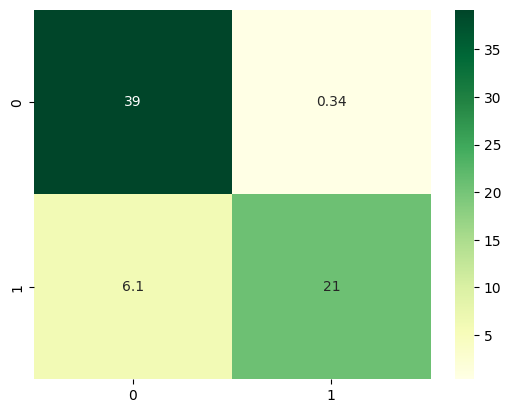

In [6]:
pred_1 = model_1.predict(X_test_transf)
#pred_1 = (model_1.predict_proba(X_test_transf)[:,1] >= 0.4).astype(bool)

conf_mat_1 = confusion_matrix(y_test, pred_1)/1000

print(classification_report(y_test, pred_1))

sns.heatmap(conf_mat_1, annot=True,  cmap='YlGn')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:    0.2s finished


              precision    recall  f1-score   support

           0       0.95      0.67      0.79     38751
           1       0.10      0.50      0.17      2798

    accuracy                           0.66     41549
   macro avg       0.52      0.59      0.48     41549
weighted avg       0.89      0.66      0.75     41549



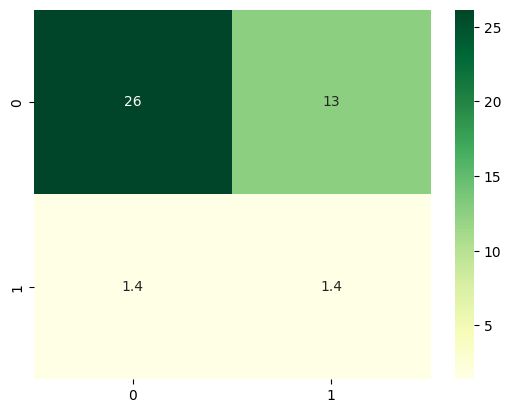

In [7]:
droped = pd.read_csv('./data/droped_states.csv')
droped['state']
X_drop = droped[(droped['state'] == 'Canceled') | (droped['state'] == 'Live')].drop('state', axis=1)
y_drop = droped[(droped['state'] == 'Canceled') | (droped['state'] == 'Live')]['state'].map({'Canceled':0, 'Live':1})

X_drop_trans = preprocessor.transform(X_drop)

pred_droped_1 = model_1.predict(X_drop_trans)
#pred_droped_1 = (model_1.predict_proba(X_drop_trans)[:,1] >= 0.4).astype(bool)

conf_mat_drop = confusion_matrix(y_drop, pred_droped_1)/1000

print(classification_report(y_drop, pred_droped_1))

sns.heatmap(conf_mat_drop, annot=True,  cmap='YlGn')

TEST_DATA_LINE = pd.DataFrame({'name': ['LETS TRY SOMETHING UNUSUAL'],
                'category': ['Music'],
                'subcategory': ['MADNESS'],
                'country': ['Germany'],
                'launched': ['2012-06-16 23:05:26'],
                'deadline': ['2032-06-16'],
                'goal': [100000],
                'pledged': [2],
                'backers':[1]})